In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csc_matrix
# import sqlite3
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, fpmax
from sklearn.naive_bayes import GaussianNB, MultinomialNB  
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [2]:
# con = sqlite3.connect('D:/hongkong record/daily course/second seminster/COMP7630/Project/data.db')
# df = pd.read_sql('select * from Keyword', con)

In [3]:
train_set = pd.read_pickle('./train_set.pkl')
train_set.drop(['id'], axis=1, inplace=True)
train_set.drop_duplicates(inplace=True)

In [4]:
train_set.shape

(149690, 3)

In [5]:
keyword = pd.read_pickle('./keyword.pkl')
movie_df = pd.read_pickle('./train_movie.pkl')

In [6]:
movie_df.head()

,tid,title,Grading,RunTime,Genres,Release,Vote,Rating,Country,Language,Production,Director,Writer,Cast,tid_enc
1,tt1598778,Contagion,PG-13,106,Action| Drama| Sci-Fi| Thriller,2011,223755,6.7,United Arab Emirates|USA,English|Mandarin|Cantonese,Warner Bros.|Participant|Imagenation Abu Dhabi FZ,Steven Soderbergh,Scott Z. Burns,Gwyneth Paltrow|Tien You Chui|Josie Ho|Daria S...,2948
2,tt7146812,Onward,PG,102,Animation| Adventure| Comedy| Family| Fantasy,2020,12211,7.7,USA,English,Walt Disney Pictures|Pixar Animation Studios,Dan Scanlon,Dan Scanlon|Keith Bunin,Tom Holland|Chris Pratt|Julia Louis-Dreyfus|Oc...,3659
14,tt6394270,Bombshell,R,109,Biography| Drama,2019,43112,6.8,USA|Canada,English,Annapurna Pictures|BRON Studios|Creative Wealt...,Jay Roach,Charles Randolph,Charlize Theron|Nicole Kidman|Margot Robbie|Jo...,3647
15,tt3281548,Little Women,PG,135,Drama| Romance,2019,75717,8.0,USA,English|French,Columbia Pictures|Instinctual VFX|New Regency ...,Greta Gerwig,Greta Gerwig|Louisa May Alcott,Saoirse Ronan|Emma Watson|Florence Pugh|Eliza ...,3441
19,tt1950186,Ford v Ferrari,PG-13,152,Action| Biography| Drama| Sport,2019,169909,8.1,USA|France,English|Italian|French|Japanese,Chernin Entertainment|Twentieth Century Fox,James Mangold,Jez Butterworth|John-Henry Butterworth,Matt Damon|Christian Bale|Jon Bernthal|Caitrio...,3131


评估language作为特征的效果

In [29]:
language_dict = {}
for row in movie_df.itertuples():
    for language in str(row.Language).split('|'):
        if language not in language_dict:
            language_dict[language] = []
        language_dict[language].append(row.tid_enc)

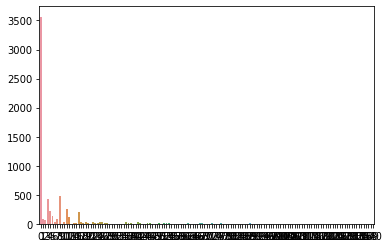

In [35]:
sns.barplot(np.arange(len(language_dict)), [len(language_dict[x]) for x in language_dict])

language 不是好特征

In [7]:
keyword.head()

,tid,keyword
1,tt7146812,singing in a car|father son bonding|brother br...
6,tt1598778,virus|contagion|infection|epidemic|outbreak|ho...
12,tt6394270,lesbian|tv show|husband wife relationship|phot...
15,tt3281548,aspiring writer|death of sister|falling throug...
18,tt1950186,based on true story|racecar|racecar driver|car...


In [8]:
from sklearn.feature_extraction.text import CountVectorizer

In [24]:
count_vect = CountVectorizer(stop_words='english')

In [26]:
keyword_dict = []
for row in keyword.itertuples():
    text = ' '.join(str(row.keyword).split('|'))
    keyword_dict.append(text)

In [30]:
count_vect.fit(keyword_dict)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

考虑过滤count小于50的单词

如果keyword不用 word2vec或embedding 将很难做交叉特征处理，数量太多

只考虑genres

In [7]:
tid_label_encoder = LabelEncoder()
tid_label_encoder.fit(train_set['tid'])

user_label_encoder = LabelEncoder()
user_label_encoder.fit(train_set['userName'])

train_set['tid_enc'] = tid_label_encoder.transform(train_set['tid'])
train_set['user_enc'] = user_label_encoder.transform(train_set['userName'])

In [8]:
h = train_set.nunique()
h

tid         3676
userName     647
rating        10
tid_enc     3676
user_enc     647
dtype: int64

In [9]:
# rating_index = train_set['rating'].sort_values().index
# rating_1_index = rating_index[:int(train_set.shape[0]/2)]
# rating_2_index = rating_index[int(train_set.shape[0]/2):]

# train_set.loc[rating_1_index, 'rating_classify'] = 1
# train_set.loc[rating_2_index, 'rating_classify'] = 2

In [9]:
train_set.loc[train_set['rating']<=5, 'rating_classify'] = 1
train_set.loc[train_set['rating']>=8, 'rating_classify'] = 2
train_set['rating_classify'].fillna(0, inplace=True)

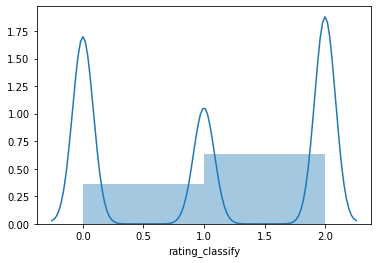

In [10]:
sns.distplot(train_set['rating_classify'], hist=True, kde=True, rug=False, bins=2)

In [11]:
rows = train_set['user_enc'].values
columns = train_set['tid_enc'].values
data = train_set['rating'].values

user_item_matrix = csc_matrix((data, (rows, columns)), shape=(h.user_enc, h.tid_enc))

In [12]:
user_item_class_matrix = csc_matrix((train_set['rating_classify'].values, \
                                     (train_set['user_enc'].values, train_set['tid_enc'].values)), shape=(h.user_enc, h.tid_enc))

In [13]:
movie_df = movie_df.sort_values(by='tid_enc')
movie_df['genres_list'] = movie_df['Genres'].str.split('|')

In [14]:
te = TransactionEncoder()
te_ary = te.fit(movie_df['genres_list']).transform(movie_df['genres_list'])
te_df_d = pd.DataFrame(te_ary, columns=te.columns_)

te_df = te_df_d.values
te_df = te_df.astype(np.int)

In [29]:
class DataSetGenerator(object):
    def __init__(self, te_df, user_item_class_matrix, user_item_matrix):
        self.sample_weight = np.array((user_item_matrix>0).sum(axis=1)).reshape(-1)
        self.sample_weight = self.sample_weight/np.sum(self.sample_weight)
        self.user_index = range(user_item_matrix.shape[0])
        self.te_df = te_df
        self.user_item_matrix = user_item_matrix
        self.user_item_class_matrix = user_item_class_matrix
        
        feature_num = te_df.shape[1]
        feature_index_matrix = np.triu((np.arange(1, feature_num*feature_num+1 ,1)).reshape((feature_num, feature_num)))
        self.feature_index = np.where(feature_index_matrix>0)
        
    def generate(self, batch, binary):
        features = []
        targets = []
        
        for num in tqdm(range(batch)):
            if binary:
                label = 0
                while True:
                    user = np.random.choice(self.user_index, 1, replace=True, p=self.sample_weight)[0]
                    item_ids = np.where((user_item_matrix[user].toarray())>0)[1]
                    select_item = np.random.choice(item_ids)
                    label = self.user_item_class_matrix[user, select_item]
                    
                    if num<(batch/2) and label==1:
                        break
                    if num>=(batch/2) and label==2:
                        break
                
                if label==2:
                    targets.append(1)
                elif label==1:
                    targets.append(0)
                    
            else:
                user = np.random.choice(self.user_index, 1, replace=True, p=self.sample_weight)[0]
                item_ids = np.where((user_item_matrix[user].toarray())>0)[1]
                select_item = np.random.choice(item_ids)
                targets.append(self.user_item_matrix[user, select_item])
            
            item_ids = item_ids[item_ids!=select_item]
            ratings = self.user_item_matrix[user, item_ids].toarray()
            
            ratings = ratings.reshape([-1,1])
            user_profile = (np.sum(self.te_df[item_ids]*ratings, axis=0)/len(item_ids)).reshape((1,-1))
            
            item_profile = te_df[select_item].reshape((-1,1))
            feature_matrix = np.dot(item_profile, user_profile)
            feature_matrix_r = feature_matrix + feature_matrix.T
            feature = feature_matrix_r[self.feature_index[0], self.feature_index[1]]
            feature = feature.reshape((-1))
            feature = feature/np.max(feature)
            
            feature = np.round(feature, 1)*10
            
            features.append(feature)
                        
        features = np.array(features)
        targets = np.array(targets).reshape((-1,1))
        
        index = np.arange(0, batch, 1)
        np.random.shuffle(index)
        features = features[index]
        targets = targets[index]
        
        return features, targets

In [28]:
# Test
# dataGenerator = DataSetGenerator(te_df ,user_item_class_matrix, user_item_matrix)
# features, targets = dataGenerator.generate(10, binary=True)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

282 2549
6 597
340 1867
334 2455
477 814
119 943
178 3496
18 2813
91 3583


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [00:00<00:00, 84.34it/s]

295 1557


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 82.18it/s]


In [25]:
# Test
# targets.sum()

5

Logistic Model

In [30]:
dataGenerator = DataSetGenerator(te_df ,user_item_class_matrix, user_item_matrix)

In [45]:
features, targets = dataGenerator.generate(40000, binary=True)

100%|███████████████████████████████████████████████████████████████████████████| 40000/40000 [02:45<00:00, 241.54it/s]


In [46]:
logisticR_model = LogisticRegression()
logisticR_model.fit(features, targets.ravel())

pre = logisticR_model.predict(features)
label = targets.reshape(-1)

print('accuracy: ',np.mean(pre==label))

D:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy:  0.63025


Random Forest Model

In [47]:
tree_model = RandomForestClassifier(n_estimators=100, min_samples_split=50)
tree_model.fit(features, targets.ravel())

pre = tree_model.predict(features)
label = targets.reshape(-1)

print('accuracy: ',np.mean(pre==label))

accuracy:  0.8199


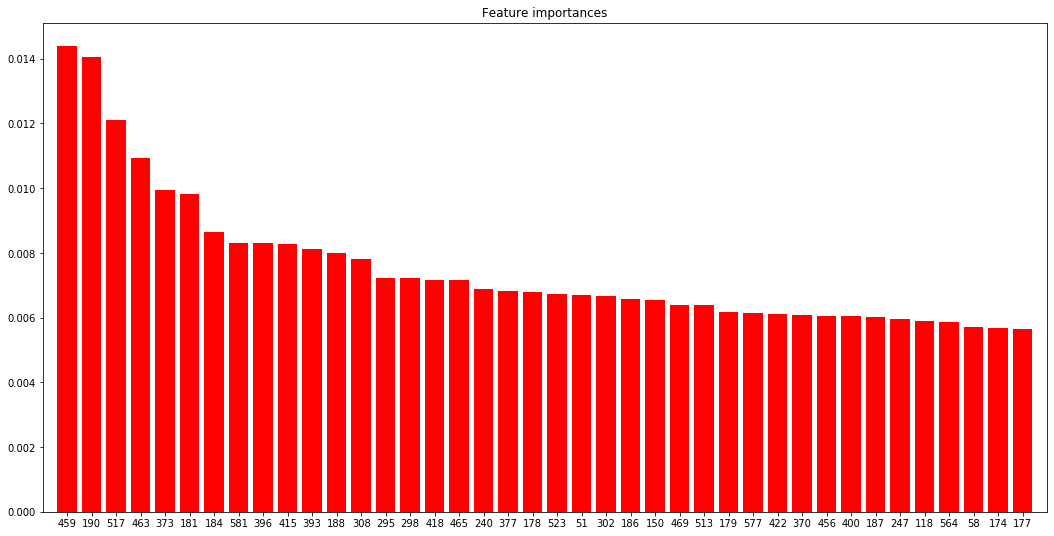

In [50]:
importances = tree_model.feature_importances_

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(18,9))
plt.title("Feature importances")
n=40
_ = plt.bar(range(n), importances[indices][:n], color="r")
plt.xticks(range(n), indices)
plt.xlim([-1, n])
plt.show()

In [51]:
feature_row_index,feature_col_index = dataGenerator.feature_index
for i in indices[:n]:
    feature_row = te_df_d.columns[feature_row_index[i]]
    feature_col = te_df_d.columns[feature_col_index[i]]
    print('%s %f'%(feature_row+' -- '+feature_col, importances[i]))

 Thriller -- Action 0.014397
 Drama -- Drama 0.014068
Action -- Comedy 0.012102
 Thriller -- Comedy 0.010929
 Mystery -- Action 0.009953
 Drama --  Thriller 0.009814
 Drama -- Action 0.008637
Comedy -- Horror 0.008320
 Romance -- Action 0.008310
 Sci-Fi --  Thriller 0.008263
 Romance --  Thriller 0.008114
 Drama -- Comedy 0.008002
 Horror -- Horror 0.007798
 Horror --  Thriller 0.007238
 Horror -- Action 0.007238
 Sci-Fi -- Action 0.007170
 Thriller -- Drama 0.007168
 Fantasy --  Thriller 0.006885
 Mystery -- Comedy 0.006833
 Drama --  Romance 0.006797
Action -- Horror 0.006741
 Adventure --  Thriller 0.006708
 Horror -- Comedy 0.006668
 Drama -- Animation 0.006564
 Crime --  Thriller 0.006545
 Thriller -- Horror 0.006398
Action -- Action 0.006375
 Drama --  Sci-Fi 0.006172
Comedy -- Drama 0.006132
 Sci-Fi -- Comedy 0.006105
 Mystery --  Thriller 0.006066
 Thriller --  Thriller 0.006058
 Romance -- Comedy 0.006036
 Drama -- Biography 0.006005
 Fantasy -- Comedy 0.005959
 Comedy --  Thr